# Imports

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn 
from sklearn.preprocessing import scale
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from collections import Counter
from pprint import pprint

In [2]:
mnist_data = pd.read_csv('mnist.csv').values

# Test Image Plotting

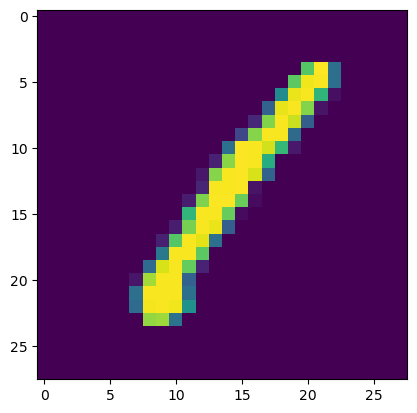

In [3]:
labels = mnist_data[:, 0]
digits = mnist_data[:, 1:]
img_size = 28
plt.imshow(digits[0].reshape(img_size, img_size))
plt.show()

# 1. Data Exploration

In [4]:
label_counts = Counter(labels)
label_percentages = {label: count/len(labels) for label, count in label_counts.items()}
pprint(label_counts)
print()
pprint(label_percentages)

Counter({1: 4684,
         7: 4401,
         3: 4351,
         9: 4188,
         2: 4177,
         6: 4137,
         0: 4132,
         4: 4072,
         8: 4063,
         5: 3795})

{0: 0.09838095238095237,
 1: 0.11152380952380953,
 2: 0.09945238095238096,
 3: 0.1035952380952381,
 4: 0.09695238095238096,
 5: 0.09035714285714286,
 6: 0.0985,
 7: 0.10478571428571429,
 8: 0.09673809523809523,
 9: 0.09971428571428571}


In [5]:
len(digits[0, :])

784

In [6]:
from collections import defaultdict

pixel_avg = defaultdict(float)
for i in range(len(digits[0, :])):
    pixel_avg[i] = sum(digits[:, i])/len(digits[:, i])

In [7]:
pprint(pixel_avg)

useless_pixels = [i for i, avg in pixel_avg.items() if avg == 0.0]
print(useless_pixels)
print(len(useless_pixels))

defaultdict(<class 'float'>,
            {0: 0.0,
             1: 0.0,
             2: 0.0,
             3: 0.0,
             4: 0.0,
             5: 0.0,
             6: 0.0,
             7: 0.0,
             8: 0.0,
             9: 0.0,
             10: 0.0,
             11: 0.0,
             12: 0.003,
             13: 0.01119047619047619,
             14: 0.005142857142857143,
             15: 0.00021428571428571427,
             16: 0.0,
             17: 0.0,
             18: 0.0,
             19: 0.0,
             20: 0.0,
             21: 0.0,
             22: 0.0,
             23: 0.0,
             24: 0.0,
             25: 0.0,
             26: 0.0,
             27: 0.0,
             28: 0.0,
             29: 0.0,
             30: 0.0,
             31: 0.0,
             32: 0.00038095238095238096,
             33: 0.0013095238095238095,
             34: 0.010547619047619047,
             35: 0.02726190476190476,
             36: 0.050904761904761904,
             37: 0.0664047

## 2. Ink feature and first model

In [17]:
# create ink feature

ink = np.array([sum(row) for row in digits])

# compute mean for each digit class
ink_mean = [np.mean(ink[labels == i]) for i in range(10)]

# compute standard deviation for each digit class
ink_std = [np.std(ink[labels == i]) for i in range(10)]

# The reshape is neccesary to call LogisticRegression() with a single feature
ink = scale(ink).reshape(-1, 1)

In [18]:
model = LogisticRegression(random_state =0).fit(ink, labels)

In [20]:
model.predict(ink)

array([1, 0, 1, ..., 2, 3, 1])

In [22]:
model.score(ink, labels)

0.22680952380952382